# Tabular models

In [18]:
from fastai.tabular import *
from datetime import datetime, timedelta
from tqdm import tqdm

Tabular data should be in a Pandas `DataFrame`.

In [34]:
path = Path('../../data/retail_dataset')
df_feature = pd.read_csv(path/'Features data set.csv')
df_sales = pd.read_csv(path/'sales data-set.csv')
df_stores = pd.read_csv(path/'stores data-set.csv')

In [35]:
df_temp = df_stores.join(df_feature.set_index('Store'), on='Store')
df = df_temp.join(df_sales.set_index(['Store','Date']), on=['Store','Date'], lsuffix='duplicate_')
df.dropna(subset=['Weekly_Sales'], inplace=True)
df.reset_index(inplace=True, drop=True)
df.head(3)

,Store,Type,Size,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHolidayduplicate_,Dept,Weekly_Sales,IsHoliday
0,1,A,151315,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,1.0,24924.50,False
1,1,A,151315,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,2.0,50605.27,False
2,1,A,151315,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,3.0,13740.12,False


In [36]:
df.shape

(421570, 17)

In [37]:
df.isnull().sum()

Store                       0
Type                        0
Size                        0
Date                        0
Temperature                 0
Fuel_Price                  0
MarkDown1              270889
MarkDown2              310322
MarkDown3              284479
MarkDown4              286603
MarkDown5              270138
CPI                         0
Unemployment                0
IsHolidayduplicate_         0
Dept                        0
Weekly_Sales                0
IsHoliday                   0
dtype: int64

In [38]:
# Let's change from Fahrenheit to Celsius
df['Temperature'] = (df['Temperature'] - 32) * 5/9

In [39]:
# Creating boolean variables that signal the presence of the markdown, True if there is a markdown, False otherwise
df = df.assign(md1_present = df.MarkDown1.notnull())
df = df.assign(md2_present = df.MarkDown2.notnull())
df = df.assign(md3_present = df.MarkDown3.notnull())
df = df.assign(md4_present = df.MarkDown4.notnull())
df = df.assign(md5_present = df.MarkDown5.notnull())

In [40]:
df.fillna(0,inplace=True)

In [41]:
df['Date'] = pd.to_datetime(df['Date'])
df = add_datepart(df,field_name='Date', drop=False)

In [42]:
medians = pd.DataFrame({'Median_Sales' :df.groupby(by=['Type','Dept','Store','Month','IsHoliday'])['Weekly_Sales'].median()}).reset_index()
medians.head()

,Type,Dept,Store,Month,IsHoliday,Median_Sales
0,A,1.0,1,1,False,17862.400
1,A,1.0,1,2,False,20124.220
2,A,1.0,1,3,False,22122.170
3,A,1.0,1,4,False,18962.285
4,A,1.0,1,5,False,17235.150


In [43]:
df = df.merge(medians, how = 'outer', on = ['Type','Dept','Store','Month','IsHoliday'])

In [44]:
df['Lagged_Date'] = df['Date']- timedelta(days=7)

In [45]:
# Make a sorted dataframe. This will allow us to find lagged variables much faster!
sorted_df = df.sort_values(['Store', 'Dept','Date'], ascending=[1, 1,1])
sorted_df = sorted_df.reset_index(drop=True) # Reinitialize the row indices for the loop to work

In [46]:
lagged_sales = []
lagged_available = []
lagged_date = sorted_df['Lagged_Date'].tolist()
date = sorted_df['Date'].tolist()
weekly_sales = sorted_df['Weekly_Sales'].tolist()
median_sales = sorted_df['Median_Sales'].tolist()
last_date = date[0]
last_sale = weekly_sales[0]
for d,lagged_d,weekly_s,median_s in tqdm(zip(date,lagged_date,weekly_sales,median_sales)):
    if (last_date == lagged_d) & (last_sale>0):
        lagged_sales.append(last_sale)
        lagged_available.append(1)
    else:
        lagged_sales.append(median_s)
        lagged_available.append(0)
    last_date = d
    last_sale = weekly_s
sorted_df['Lagged_Sales'] = lagged_sales
sorted_df['Lagged_Available'] = lagged_available

421570it [00:00, 1382230.99it/s]


In [47]:
df = df.merge(sorted_df[['Dept', 'Store','Date','Lagged_Sales','Lagged_Available']], how = 'inner', on = ['Dept', 'Store','Date'])

In [48]:
df['Sales_dif'] = df['Median_Sales'] - df['Lagged_Sales']
df[['Dept', 'Store','Date','Lagged_Date','Lagged_Sales','Weekly_Sales','Median_Sales']].head()

,Dept,Store,Date,Lagged_Date,Lagged_Sales,Weekly_Sales,Median_Sales
0,1.0,1,2010-05-02,2010-04-25,17235.15,24924.50,17235.15
1,1.0,1,2010-05-03,2010-04-26,17235.15,21827.90,17235.15
2,1.0,1,2010-05-14,2010-05-07,17235.15,18926.74,17235.15
3,1.0,1,2010-05-21,2010-05-14,18926.74,14773.04,17235.15
4,1.0,1,2010-05-28,2010-05-21,14773.04,15580.43,17235.15


In [49]:
df['Difference'] = df['Median_Sales'] - df['Weekly_Sales']

In [50]:
df['Black_Friday'] = np.where((df['Date']==datetime(2010, 11, 26).date()) | 
                              (df['Date']==datetime(2011, 11, 25).date()), 'yes', 'no')
df['Pre_christmas'] = np.where((df['Date']==datetime(2010, 12, 23).date()) | 
                               (df['Date']==datetime(2010, 12, 24).date()) | 
                               (df['Date']==datetime(2011, 12, 23).date()) | 
                               (df['Date']==datetime(2011, 12, 24).date()), 'yes', 'no')

In [191]:
df['Weekly_Sales_log'] = df.Weekly_Sales.apply(lambda x: np.log(np.abs(x)) if x!=0 else 0)
df.Weekly_Sales_log.describe()

count    421570.000000
mean          8.501574
std           2.075910
min          -4.605170
25%           7.640007
50%           8.937485
75%           9.913728
max          13.448929
Name: Weekly_Sales_log, dtype: float64

In [55]:
df.columns

Index(['Store', 'Type', 'Size', 'Date', 'Temperature', 'Fuel_Price',
       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'IsHolidayduplicate_', 'Dept', 'Weekly_Sales',
       'IsHoliday', 'md1_present', 'md2_present', 'md3_present', 'md4_present',
       'md5_present', 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
       'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
       'Is_year_end', 'Is_year_start', 'Elapsed', 'Median_Sales',
       'Lagged_Date', 'Lagged_Sales', 'Lagged_Available', 'Sales_dif',
       'Difference', 'Black_Friday', 'Pre_christmas'],
      dtype='object')

In [172]:
dep_var = 'Weekly_Sales'
cat_names = ['Store', 'Type','Dept','IsHoliday', 'md1_present', 'md2_present', 'md3_present', 'md4_present',
       'md5_present','Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
       'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
       'Is_year_end', 'Is_year_start','Lagged_Available','Black_Friday', 'Pre_christmas']
cont_names = ['Size', 'CPI', 'Temperature', 'Fuel_Price', 'Unemployment','Sales_dif',
             'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5','Lagged_Sales']
procs = [FillMissing, Categorify, Normalize]

In [190]:
df.sort_values(by='Date', inplace=True)
df.reset_index(drop=True,inplace=True)

In [192]:
df_validation = df.iloc[-2000:].copy()
test = TabularList.from_df(df_validation, path=path, cat_names=cat_names, cont_names=cont_names)

In [193]:
data = (TabularList.from_df(df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(list(df_validation.index))
                           .label_from_df(cols=dep_var, label_cls=FloatList, log=False)
                           .add_test(test)
                           .databunch())

In [166]:
data.show_batch(rows=10)

IsHoliday,Black_Friday,Pre_christmas,Size,CPI,Temperature,Fuel_Price,Unemployment,Sales_dif,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Lagged_Sales,target
False,no,no,-0.3646,-0.9267,0.1706,1.4674,-1.7011,0.7271,-0.4276,-0.1728,-0.0842,-0.2782,-0.3950,0.2541,4653.55
False,no,no,-0.1797,1.1369,-0.8794,-0.7642,-0.8254,0.3282,-0.4276,-0.1728,-0.0842,-0.2782,-0.3950,0.3021,2025.32
False,no,no,0.2569,-0.8833,-0.7201,0.5935,-0.1924,0.0419,-0.4276,-0.1728,-0.0842,-0.2782,-0.3950,-0.4318,539.095
False,no,no,-1.5857,-1.0202,0.2736,0.9748,-1.2512,0.0419,-0.2992,-0.1728,-0.0842,-0.2782,-0.1297,-0.2268,-2234.73
False,no,no,-0.3043,0.3379,-1.1640,0.1576,0.3169,0.0419,-0.4276,-0.1728,-0.0842,-0.2782,-0.3950,0.3649,36.135
False,no,no,-1.5893,-1.0178,0.3158,2.0492,1.2006,-0.0616,-0.4031,-0.1714,-0.0837,-0.2782,-0.3132,-0.4253,-487.13
False,no,no,0.7739,1.1128,1.2460,0.3603,0.1177,0.0419,-0.4276,-0.1728,-0.0842,-0.2782,-0.3950,-0.4547,820.62
False,no,no,-0.1686,-1.0508,-0.5201,0.2796,-0.0446,0.0419,-0.0643,-0.1065,0.1333,-0.2375,0.4297,1.9649,5500.03
False,no,no,1.3550,-1.1315,-1.8606,-1.1957,-0.0869,0.0419,-0.4276,-0.1728,-0.0842,-0.2782,-0.3950,-0.5357,-2058.08
False,no,no,-1.6269,1.2874,0.2052,-0.1148,-0.4072,0.0114,-0.1991,-0.1682,-0.0806,-0.0564,0.2992,-0.6359,-14.59


In [ ]:
max_log_y = (np.max(df['Weekly_Sales_log'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [194]:
learn = tabular_learner(data, layers=[600,300],  metrics=[rmse, mae, accuracy],loss_func=mae)

epoch,train_loss,valid_loss,root_mean_squared_error,mean_absolute_error,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


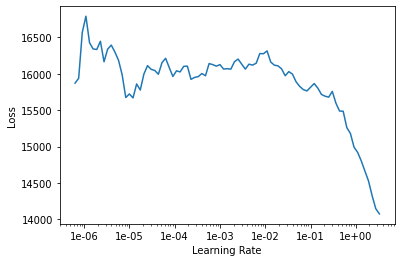

In [195]:
learn.lr_find();
learn.recorder.plot()

In [196]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,root_mean_squared_error,mean_absolute_error,accuracy,time
0,4856.036621,5180.488770,11870.634766,5180.488770,0.000000,00:59
1,3578.649414,3400.650391,6058.312500,3400.649902,0.000000,00:59
2,3218.259033,2574.721924,4792.583984,2574.721680,0.000000,01:03
3,3181.484375,2740.254150,4424.520020,2740.254150,0.000000,01:01
4,3126.948975,2606.309570,4528.404785,2606.310059,0.000000,01:02
5,3327.805420,16913.343750,112014.632812,16913.345703,0.000000,01:02
6,3167.290527,2143.581055,3649.749512,2143.580811,0.000000,01:01
7,2822.673340,2874.220215,5080.712402,2874.219971,0.000000,01:04
8,2938.149414,2678.266602,4798.750488,2678.266602,0.000000,01:04
9,2826.792236,2745.614502,5484.038574,2745.614746,0.000000,01:04


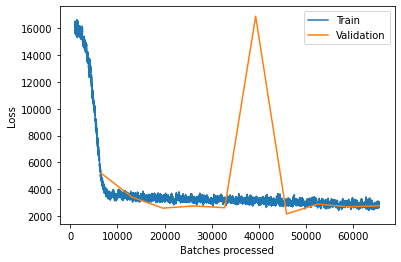

In [197]:
learn.recorder.plot_losses(skip_start=1000)

## Inference

In [182]:
preds, targets= learn.get_preds(DatasetType.Test)
labels = [np.exp(p[0].data.item()) for p in preds]

/home/jacek/workspace/fastai_course-v3/env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [183]:
df_validation['predicted'] = labels